<a href="https://colab.research.google.com/github/ese-msc-2022/acds-moonshot-xenophanes/blob/olya/yolo_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: ignored

In [15]:

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Jan 30 20:47:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
%%bash
pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.7 MB/s eta 0:00:00


In [60]:
# import the modules
import os
from os import listdir
import shutil
import csv

import torch
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from sklearn.model_selection import train_test_split



In [20]:
print(os.getcwd())
dir = '/content/drive/MyDrive/Colab Notebooks/Olya'
yolo_dir = f'{dir}/yolov5'
data_dir = f'{dir}/data'
dataset_dir = f'{dir}/dataset'

In [30]:
#splitting the dataset
random.seed(41)

# Read images and annotations
images = os.listdir(f'{data_dir}/images/')
labels = os.listdir(f'{data_dir}/labels/')
images.sort()
labels.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size = 0.3, random_state = 1)

for _ in ['train','val']:
  for __ in ['images','labels']:
    print(globals()[f"{_}_{__}"])
    for i in globals()[f"{_}_{__}"]:
      print((f'Copying: {data_dir}/{__}/{i} to {dataset_dir}/{__}/{_}/{i}'))   
      shutil.copyfile(f'{data_dir}/{__}/{i}', f'{dataset_dir}/{__}/{_}/{i}')
      



['amenthes_41_31.png', 'arabia_12_20.png', 'amazonis_10_2.png', 'syrtismajor_47_11.png', 'coprates_29_9.png', 'margaritifersinus_11_11.png', 'tharsis_34_35.png', 'arabia_10_41.png', 'oxiapalus_26_37.png', 'lunaepalus_22_10.png', 'margaritifersinus_35_11.png', 'margaritifersinus_23_11.png', 'tharsis_27_22.png', 'amazonis_42_19.png', 'maretyrrhenum_35_8.png', 'phoenicislacus_20_32.png', 'margaritifersinus_17_34.png', 'phoenicislacus_52_2.png', 'phoenicislacus_13_9.png', 'aeolis_54_0.png', 'elysium_30_29.png', 'phoenicislacus_11_18.png', 'coprates_15_10.png', 'phoenicislacus_23_30.png', 'tharsis_33_7.png', 'phoenicislacus_63_9.png', 'sinussabaeus_19_4.png', 'coprates_31_12.png', 'elysium_52_30.png', 'elysium_35_41.png', 'amazonis_28_35.png', 'phoenicislacus_62_6.png', 'tharsis_35_6.png', 'margaritifersinus_39_5.png', 'elysium_63_29.png', 'tharsis_24_27.png', 'arabia_18_1.png', 'elysium_56_32.png', 'amenthes_52_0.png', 'lunaepalus_15_26.png', 'margaritifersinus_26_22.png', 'iapygia_61_37.p

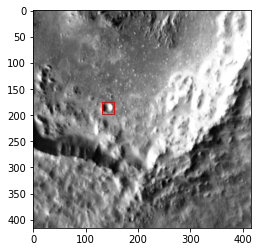

In [117]:
#plot example test image with lable
#Load the image
img = f'{dataset_dir}/images/train/{train_images[0]}'
#img = f'{dataset_dir}/images/train/amazonis_14_11.png'#{train_images[0]}'

_ = Image.open(img)
fig, ax = plt.subplots()
ax.imshow(_, cmap='gray')

#load the lable
lbl = img.replace("images", "labels").replace("png", "csv")
my_coords = np.genfromtxt(lbl, delimiter=',')

w,h = _.size
if my_coords.ndim == 1:
  rect = patches.Rectangle((my_coords[0]*w-(my_coords[2]*w/2), my_coords[1]*h-(my_coords[3]*h/2)), my_coords[2]*w, my_coords[3]*h, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
else:  
  rect={}
  for i in range(my_coords.ndim):
    rect[i] = patches.Rectangle((my_coords[i][0]*w-(my_coords[i][2]*w/2), my_coords[i][1]*h-(my_coords[i][3]*h/2)), my_coords[i][2]*w, my_coords[i][3]*h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect[i])

plt.show()

  



In [118]:
# we need to convert csv to txt for lables
csv_file = raw_input('Enter the name of your input file: ')
txt_file = raw_input('Enter the name of your output file: ')
with open(txt_file, "w") as my_output_file:
    with open(csv_file, "r") as my_input_file:
        [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

416


In [125]:

!python '{yolo_dir}/train.py' --img 416 --cfg yolov5s.yaml --hyp moon_hyp_params.yaml --batch 32 --epochs 100 --data moon.yaml --weights yolov5s.pt --workers 24 --name yolo_moons


train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=moon.yaml, hyp=moon_hyp_params.yaml, epochs=100, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=drive/MyDrive/Colab Notebooks/Olya/yolov5/runs/train, name=yolo_moons, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
fatal: cannot change to '/content/drive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2023-1-30 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, bo